In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
df0 = pd.read_csv('data/annual_csi_data_for_match.csv', sep=',')

# Data Cleaning

In [3]:
df0.rename(index=str, columns={"datatime": "datetime"}, inplace=True)
df0['datetime'] = pd.to_datetime(df0['datetime'])
df0.reset_index(drop = True, inplace = True)

In [4]:
# Make copy of raw import
df = df0.copy()

In [5]:
# Function for converting datetime data into just year
def dt_to_year(df):
    df['year'] = np.zeros(df.shape[0])
    for i, el in df['datetime'].iteritems():
        df.at[i,'year'] = el.year
    df['year'] = df['year'].astype(int)
    df.drop(['datetime'], axis=1, inplace=True)

In [6]:
dt_to_year(df)

In [7]:
# Convert lat/lon to 2 decimals for NASA API
df.reset_index(drop = True, inplace = True)
df['lat'] = round(df['lat'],2)
df['lon'] = round(df['lon'],2)

### Save this df for NASA data to match lat/lon/year in 'Nasa weather merge script'

In [8]:
df.to_csv('data/readyforweath.csv',index=False)

### (cont. cleaning)

In [9]:
def clean_data(df):    
    drop_list = ['city', 'cod', 'panelmodel','invertermodel','pr','lon','invertermake','panelmake']
    df.drop(drop_list, axis=1, inplace=True)
    df.paneltype.fillna(value = 'poly', inplace=True)
    df.mount_type.fillna(value = 'Fixed - Roof Mounted', inplace=True)
    df['cellcategory'].replace('Unknown', 'Standard', inplace=True)
    df['azimuth'].replace('Mixed', 180, inplace=True)
    df['azimuth'] = df['azimuth'].astype(float)
    df['tilt'].replace('Mixed', round(df['lat'],1),inplace=True)
    df['tilt'] = df['tilt'].astype(float)
    df['lat'] = round(df['lat'],1)
    
    # Get opt tilt & azimuth
    tilt = df['tilt'].values.astype(float)
    lat = df['lat'].values.astype(float)
    az = df['azimuth'].values
    df['opt_tilt'] = abs(tilt-lat)
    df['opt_az'] = abs(az-180)
    
    #Group panel types != poly/mono to other
    for i, el in df['paneltype'].iteritems():
        if el not in ['poly','mono']:
            df.at[i,'paneltype']='other'
    return df

In [10]:
df = clean_data(df)

In [11]:
df = pd.get_dummies(df,columns = ['mount_type','koeppen','paneltype','cellcategory'], drop_first=True)

In [12]:
cols = ['actualkwh','capacity_dc_kw','opt_tilt','opt_az', 
       'mount_type_Fixed - Roof Mounted', 'koeppen_Moderate', 'paneltype_other', 'paneltype_poly',
        'cellcategory_Premium', 'cellcategory_Standard',
       'cellcategory_Thin Film']
df = df.reindex(cols, axis=1)

In [15]:
df.to_csv('data/df_kg_final.csv',index=False)

# Let's join the NASA data

In [16]:
nasa = pd.read_csv('data/nasa_weather.csv')
csi = pd.read_csv('data/df_kg_final.csv')

In [17]:
print(nasa.shape, csi.shape)

(8157, 6) (8157, 11)


In [18]:
df_csi_nasa = csi.join(nasa)

In [19]:
df_csi_nasa.to_csv('data/df_csi_nasa.csv',index=False)

In [20]:
df_csi_nasa.shape

(8157, 17)

# EDA: Let's look at the data

In [21]:
df = pd.read_csv('data/df_csi_nasa.csv')

### Distributions

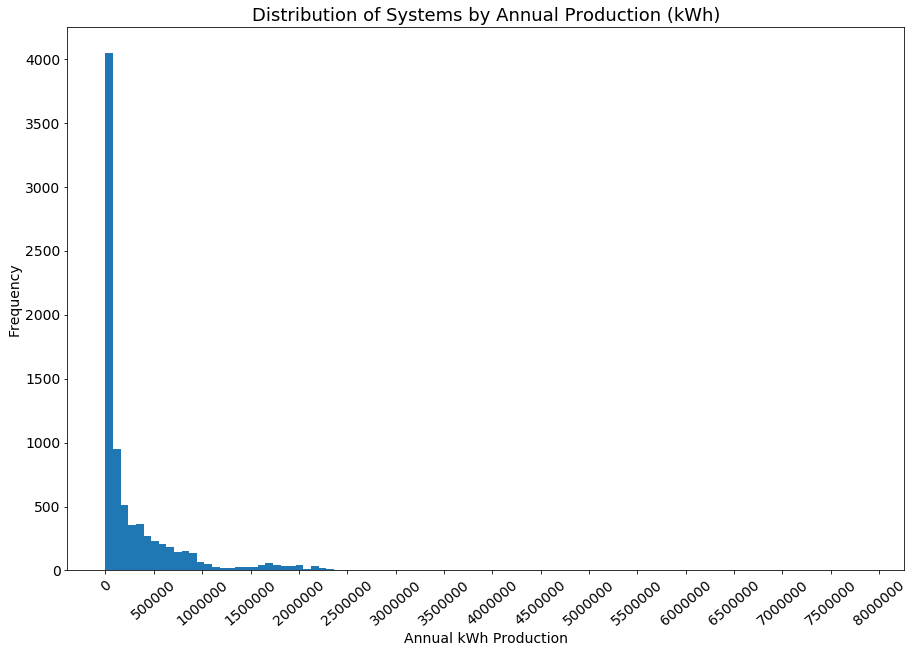

In [22]:
hist_x = df['actualkwh'].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency',fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,8000000,17), fontsize='14', rotation='40')
plt.title('Distribution of Systems by Annual Production (kWh)', fontsize='18')
plt.hist(hist_x, bins=100);

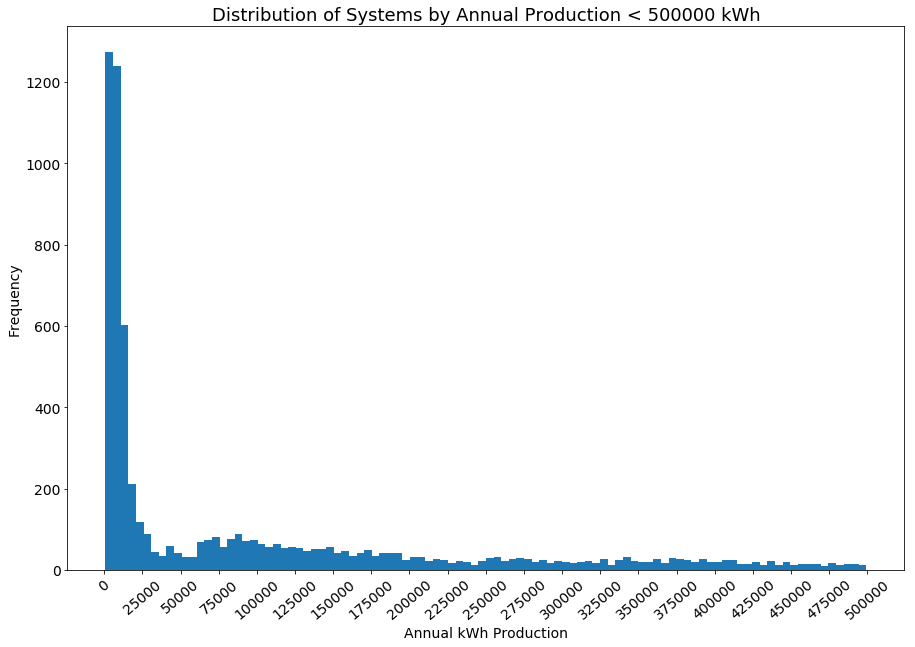

In [23]:
hist_x = df['actualkwh'][df['actualkwh']<500000].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.xticks(np.linspace(0,500000,21), fontsize='14', rotation='40')
plt.yticks(fontsize='14')
plt.title('Distribution of Systems by Annual Production < 500000 kWh', fontsize='18')
plt.hist(hist_x, bins=100);

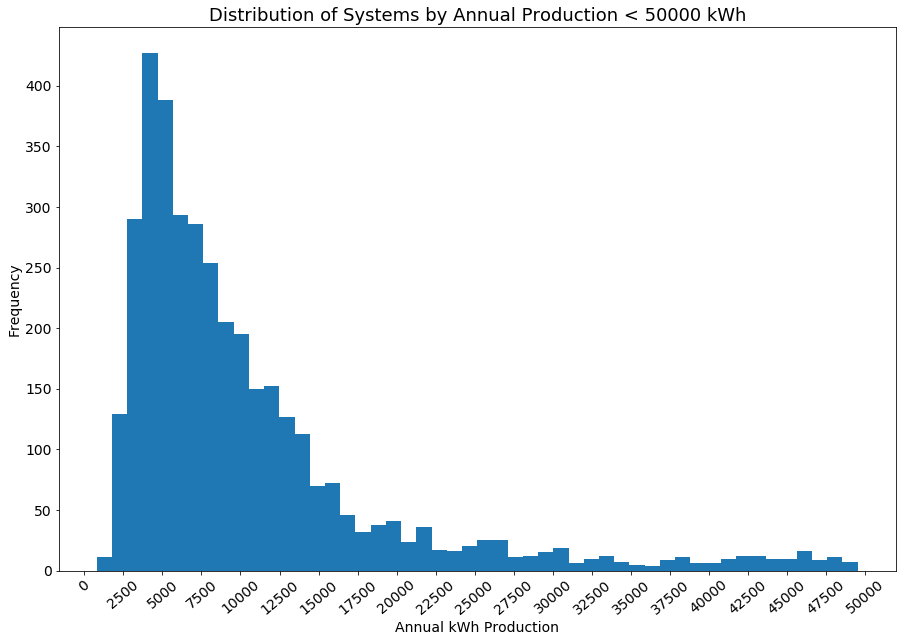

In [24]:
hist_x = df['actualkwh'][df['actualkwh']<50000].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('Annual kWh Production', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.xticks(np.linspace(0,50000,21), fontsize='14', rotation='40')
plt.yticks(fontsize='14')
plt.title('Distribution of Systems by Annual Production < 50000 kWh', fontsize='18')
plt.hist(hist_x, bins=50);

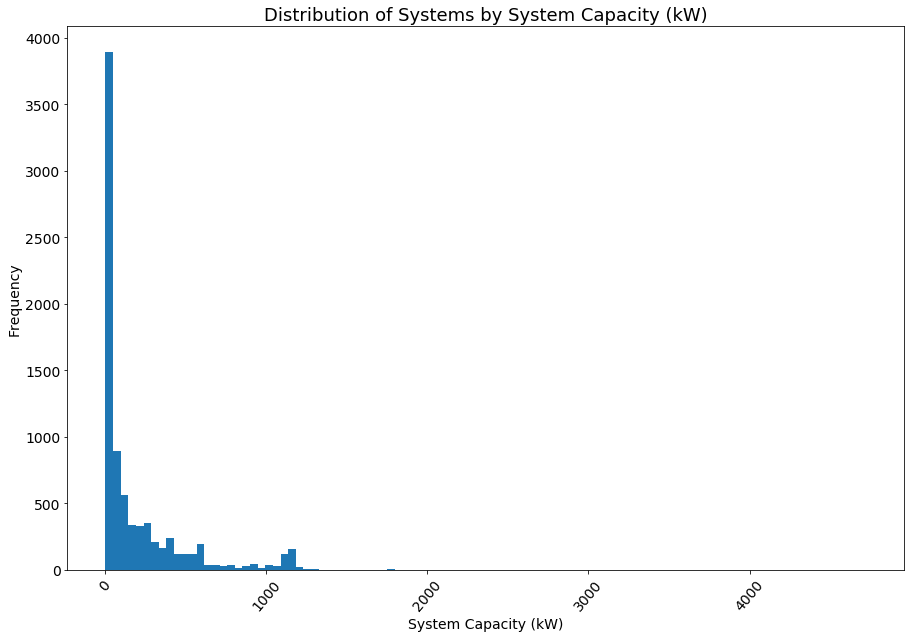

In [25]:
hist_x = df['capacity_dc_kw'].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity (kW)', fontsize='18')
plt.hist(hist_x, bins=100);

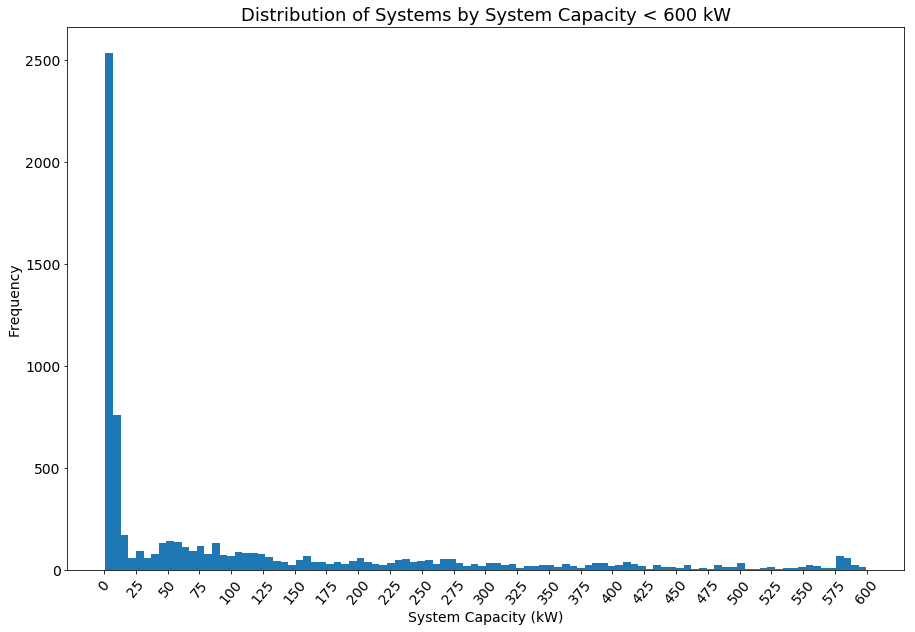

In [26]:
hist_x = df['capacity_dc_kw'][df['capacity_dc_kw']<600].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,600,25), fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity < 600 kW', fontsize='18')
plt.hist(hist_x, bins=100);

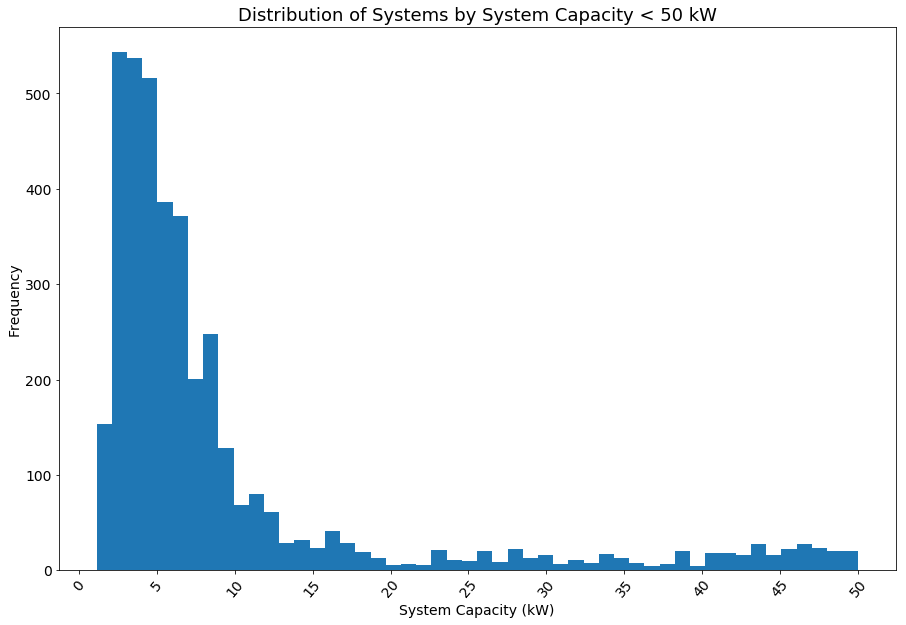

In [27]:
hist_x = df['capacity_dc_kw'][df['capacity_dc_kw']<50].values
fig = plt.figure(figsize=(15,10))
plt.xlabel('System Capacity (kW)', fontsize='14')
plt.ylabel('Frequency', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(0,50,11), fontsize='14', rotation='50')
plt.title('Distribution of Systems by System Capacity < 50 kW', fontsize='18')
plt.hist(hist_x, bins=50);

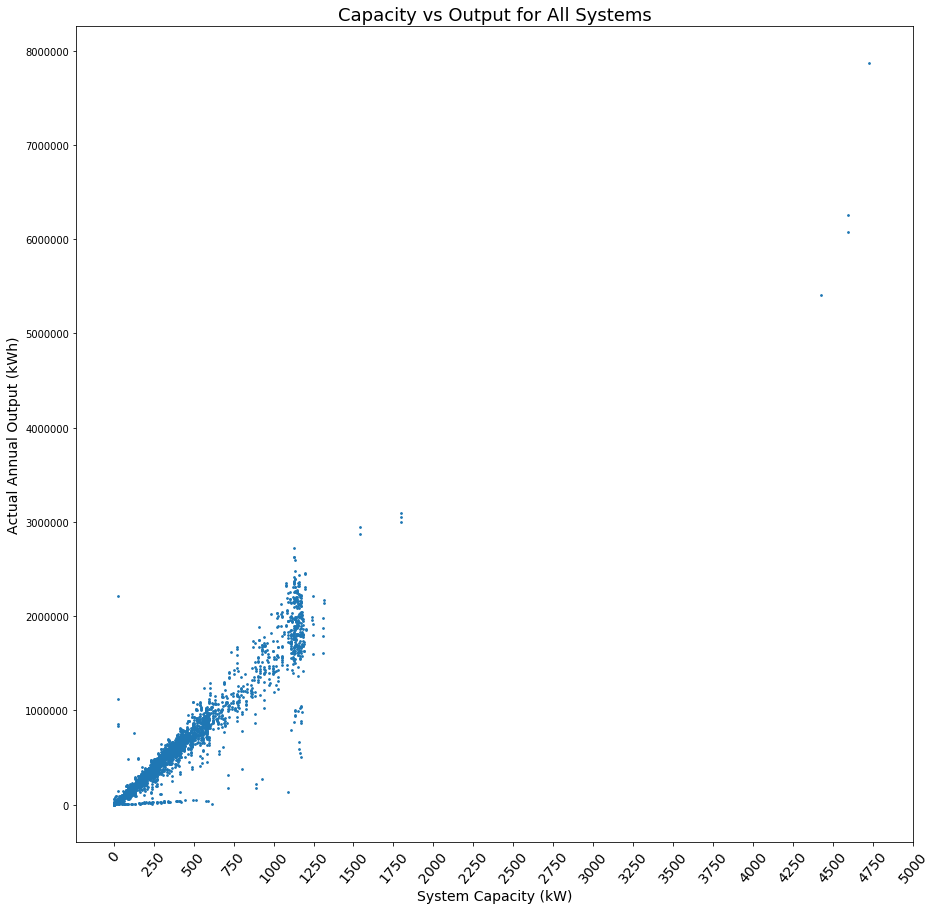

In [28]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'].values, df['actualkwh'].values, s=3)
plt.title("Capacity vs Output for All Systems",fontsize='18')
# plt.yticks(np.linspace(0,900000,19))
plt.xticks(np.linspace(0,5000,21), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

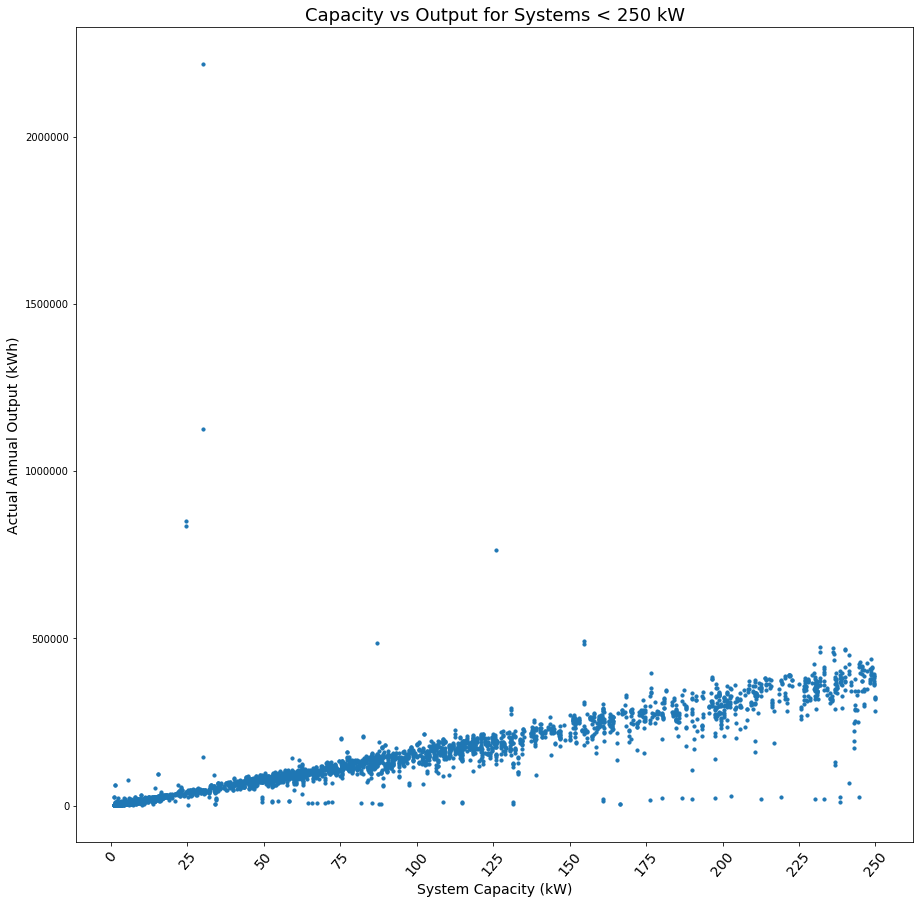

In [29]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'][df['capacity_dc_kw']<250].values, df['actualkwh'][df['capacity_dc_kw']<250].values, s=10)
plt.title("Capacity vs Output for Systems < 250 kW",fontsize='18')
# plt.yticks(np.linspace(0,900000,19))
plt.xticks(np.linspace(0,250,11), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

### Looks like there are cases of over reporting production. Let's remove the outliers

In [30]:
df['efficiency'] = df['actualkwh'] / df['capacity_dc_kw']

eff_std = df.efficiency.std()
eff_mean = df.efficiency.mean()

(8146, 18)

In [ ]:
# Removing outliers > 4 std devs away from mean
efficiency_mask = np.abs((eff_mean - df['efficiency'])/eff_std) < 4

df = df.loc[efficiency_mask, :]
df.shape

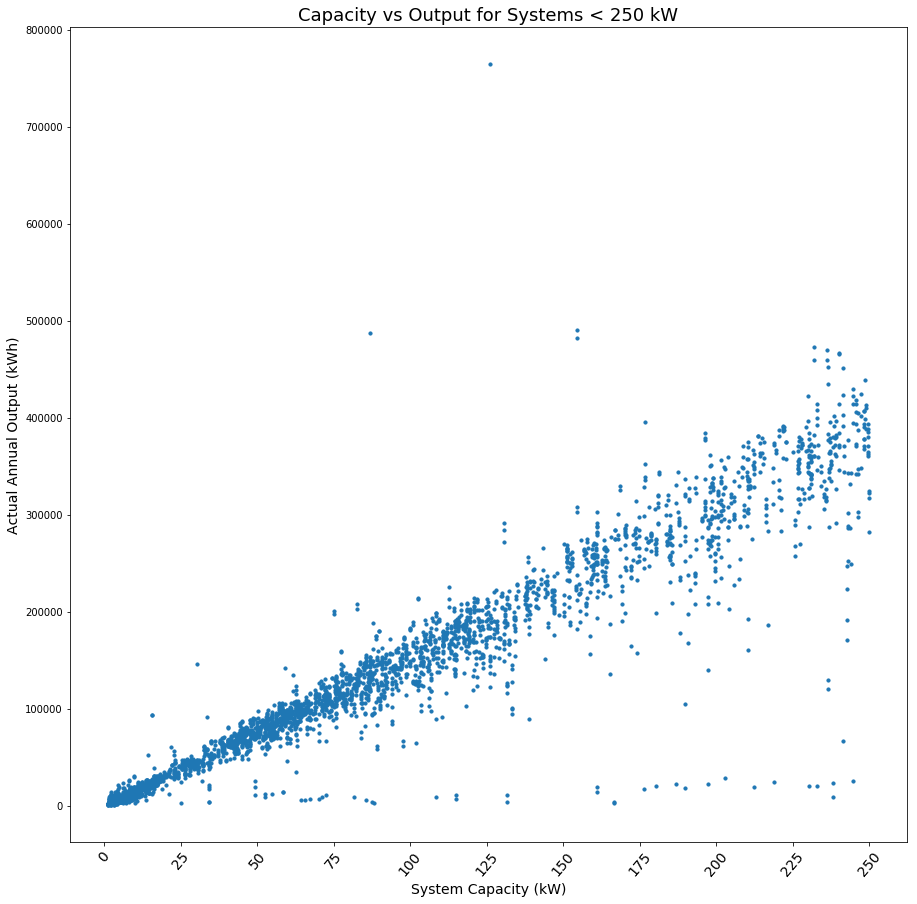

In [31]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'][df['capacity_dc_kw']<250].values, df['actualkwh'][df['capacity_dc_kw']<250].values, s=10)
plt.title("Capacity vs Output for Systems < 250 kW",fontsize='18')

plt.xticks(np.linspace(0,250,11), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

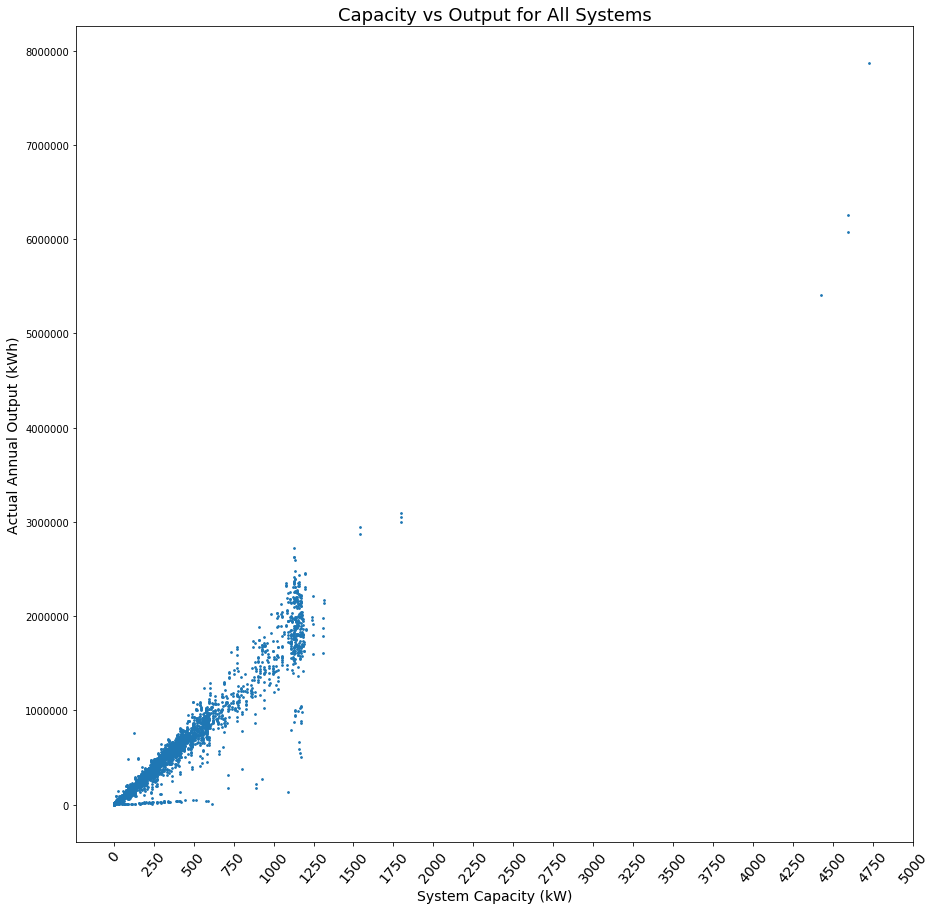

In [32]:
plt.figure(figsize=(15,15))
plt.scatter(df['capacity_dc_kw'].values, df['actualkwh'].values, s=3)
plt.title("Capacity vs Output for All Systems",fontsize='18')
# plt.yticks(np.linspace(0,900000,19))
plt.xticks(np.linspace(0,5000,21), fontsize='14', rotation='50')
plt.xlabel("System Capacity (kW)",fontsize='14')
plt.ylabel("Actual Annual Output (kWh)",fontsize='14');

In [34]:
# drop efficiency metric before we export for modeling
df.drop('efficiency', axis=1, inplace=True)

In [35]:
df.to_csv('data/df_for_modeling.csv', index=False)

# Modeling

### 1. Baseline (mean)

In [53]:
df_base0 = pd.read_csv('data/df_for_modeling.csv')
df_base = df_base0.copy()

In [54]:
y = df_base.pop('actualkwh')

df_base['mean'] = np.mean(y)
y_mean = df_base.pop('mean')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(y_mean, y, train_size=.75, test_size=.25, random_state=42)

In [56]:
r2 = r2_score(y_test, X_test)
print('Baseline R-squared:',round(r2,3))

Baseline R-squared: -0.0


In [57]:
base_mse = mean_squared_error(y_test, X_test)
print('Baseline rmse:',round(base_mse**.5,1))

Baseline rmse: 477643.5


### 2. Linear Regression

In [59]:
df = df_base0.copy()
y = df.pop('actualkwh')
X = df

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75, test_size=.25, random_state=42)

In [86]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
r2 = linreg.score(X_test, y_test)
print('LR R-squared:',round(r2,3))

LR R-squared: 0.963


In [63]:
y_pred = linreg.predict(X_test)
lr_mse = mean_squared_error(y_test,y_pred)
print('LR rmse: ',round(lr_mse**.5,1))

LR rmse:  91354.7


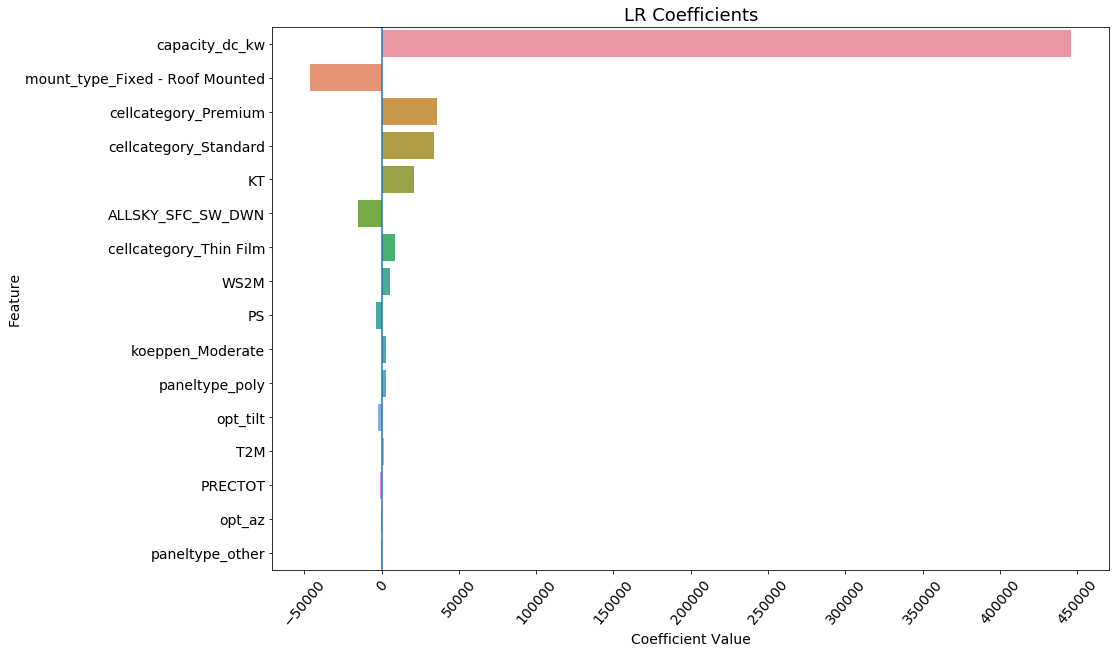

In [76]:
# Plot coefficients
coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': linreg.coef_,
    'abs_coef': np.abs(linreg.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(15,10))
sns.barplot(x=coefs.coefficient.head(16), y=coefs.feature.head(16), orient='h')

plt.axvline(x=0)
plt.title("LR Coefficients", fontsize='18')
plt.ylabel('Feature', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(-50000,450000,11), rotation=50,fontsize='14')
plt.xlabel('Coefficient Value', fontsize='14');

In [67]:
coefs

,feature,coefficient,abs_coef
0,capacity_dc_kw,446158.383271,446158.383271
3,mount_type_Fixed - Roof Mounted,-46049.942968,46049.942968
7,cellcategory_Premium,36011.574899,36011.574899
8,cellcategory_Standard,33701.093267,33701.093267
11,KT,20826.919310,20826.919310
10,ALLSKY_SFC_SW_DWN,-14912.028654,14912.028654
9,cellcategory_Thin Film,8597.345570,8597.345570
15,WS2M,5221.811084,5221.811084
13,PS,-3547.672663,3547.672663
4,koeppen_Moderate,3172.106765,3172.106765


In [ ]:
# Pickle LR model

In [88]:
pickle.dump(linreg, open('linreg_model_final.pkl', 'wb'))

### 3. Elastic Net

In [82]:
# Can use same train/test split data
# Grid Search
params = {
    'alpha': np.linspace(.001,.1,10),
    'l1_ratio': np.linspace(0,1,5)
}
en = ElasticNet()
gs_en = GridSearchCV(en, params, cv=3, verbose=1, n_jobs = 4)

gs_en.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/matchdt/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

GridSearchCV(cv=3, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'alpha': array([0.001, 0.012, 0.023, 0.034, 0.045, 0.056, 0.067, 0.078, 0.089,
       0.1  ]), 'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [83]:
gs_en_bestr2 = gs_en.best_score_
gs_en_params = gs_en.best_params_
gs_en_r2_test = gs_en.score(X_test, y_test)
print('gs_en_bestr2:',gs_en_bestr2)
print('gs_en_params:',gs_en_params)
print('gs_en_r2_test:',gs_en_r2_test)

gs_en_bestr2: 0.9570872102670378
gs_en_params: {'alpha': 0.012, 'l1_ratio': 0.75}
gs_en_r2_test: 0.9633752933164423


In [84]:
en = ElasticNet(alpha= .012, l1_ratio=.75)
en.fit(X_train, y_train)

ElasticNet(alpha=0.012, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
en_r2 = en.score(X_test, y_test)
print('EN R-squared:',round(en_r2,3))
y_pred = en.predict(X_test)
en_mse = mean_squared_error(y_test,y_pred)
print('EN rmse: ',round(en_mse**.5,1))

EN R-squared: 0.963
EN rmse:  91408.1


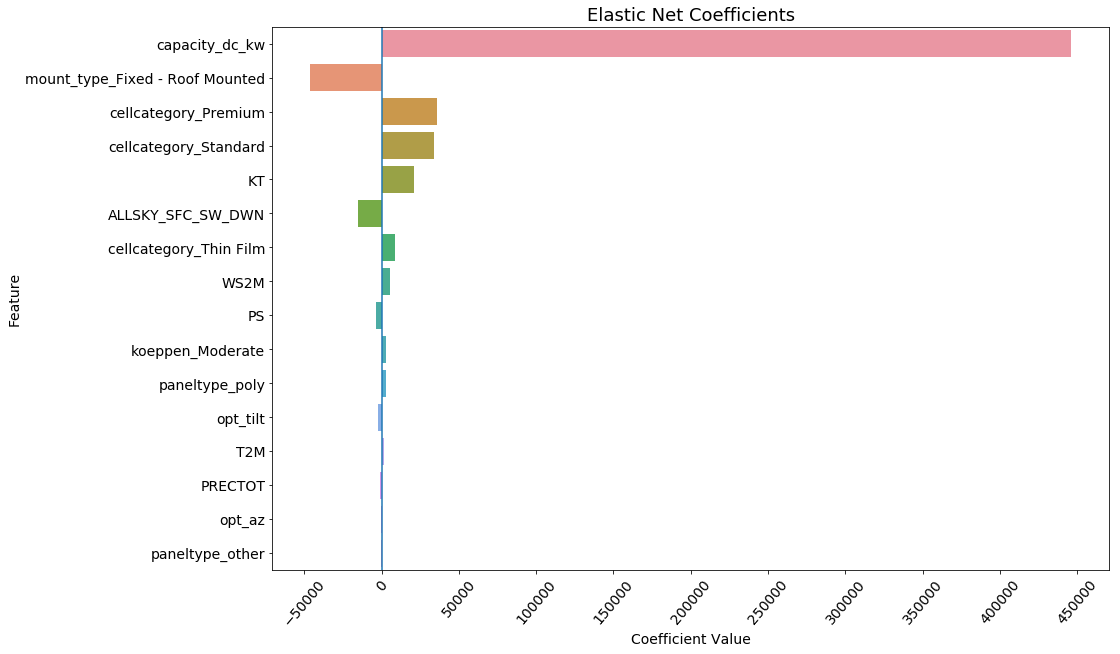

In [85]:
coefs_en = pd.DataFrame({
    'feature': X.columns,
    'coefficient': en.coef_,
    'abs_coef': np.abs(en.coef_)
})
coefs_en.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(15,10))
sns.barplot(x=coefs.coefficient.head(16), y=coefs.feature.head(16), orient='h')

plt.axvline(x=0)
plt.title("Elastic Net Coefficients", fontsize='18')
plt.ylabel('Feature', fontsize='14')
plt.yticks(fontsize='14')
plt.xticks(np.linspace(-50000,450000,11), rotation=50,fontsize='14')
plt.xlabel('Coefficient Value', fontsize='14');

In [89]:
coefs_en

,feature,coefficient,abs_coef
0,capacity_dc_kw,444468.107387,444468.107387
3,mount_type_Fixed - Roof Mounted,-46463.772737,46463.772737
8,cellcategory_Standard,27006.504582,27006.504582
7,cellcategory_Premium,20477.753598,20477.753598
11,KT,19090.803871,19090.803871
10,ALLSKY_SFC_SW_DWN,-12583.544471,12583.544471
9,cellcategory_Thin Film,7215.577503,7215.577503
6,paneltype_poly,-5946.937465,5946.937465
15,WS2M,5034.429290,5034.429290
5,paneltype_other,-4465.811925,4465.811925


### 4. Random Forest

In [90]:
# No scaling necessary
df_rf = df_base0.copy()
y = df_rf.pop('actualkwh')
X = df_rf

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, test_size=.25, random_state=42)

In [92]:
# Creating gridsearch to find optimal parameters.
params = {
    'max_depth': np.linspace(50,150,6),
    'n_estimators': np.linspace(100,400,4, dtype=int)
}

rf = RandomForestRegressor()
gs_rf = GridSearchCV(rf, params, cv=3, verbose=1,n_jobs=4)

In [93]:
gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': array([ 50.,  70.,  90., 110., 130., 150.]), 'n_estimators': array([100, 200, 300, 400])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [94]:
gs_rf_bestr2 = gs_rf.best_score_
gs_rf_params = gs_rf.best_params_
gs_rf_r2_test = gs_rf.score(X_test, y_test)
print('gs_rf_bestr2:',gs_rf_bestr2)
print('gs_rf_params:',gs_rf_params)
print('gs_rf_r2_test:',gs_rf_r2_test)

gs_rf_bestr2: 0.9556262641558675
gs_rf_params: {'max_depth': 70.0, 'n_estimators': 100}
gs_rf_r2_test: 0.9750389390872846


In [95]:
rf = RandomForestRegressor(max_depth=70, n_estimators=100,n_jobs=4)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [96]:
rf_r2 = rf.score(X_test, y_test)
print('RF R-squared:',round(rf_r2,3))
y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test,y_pred)
print('RF rmse: ',round(rf_mse**.5,1))

RF R-squared: 0.976
RF rmse:  74653.6


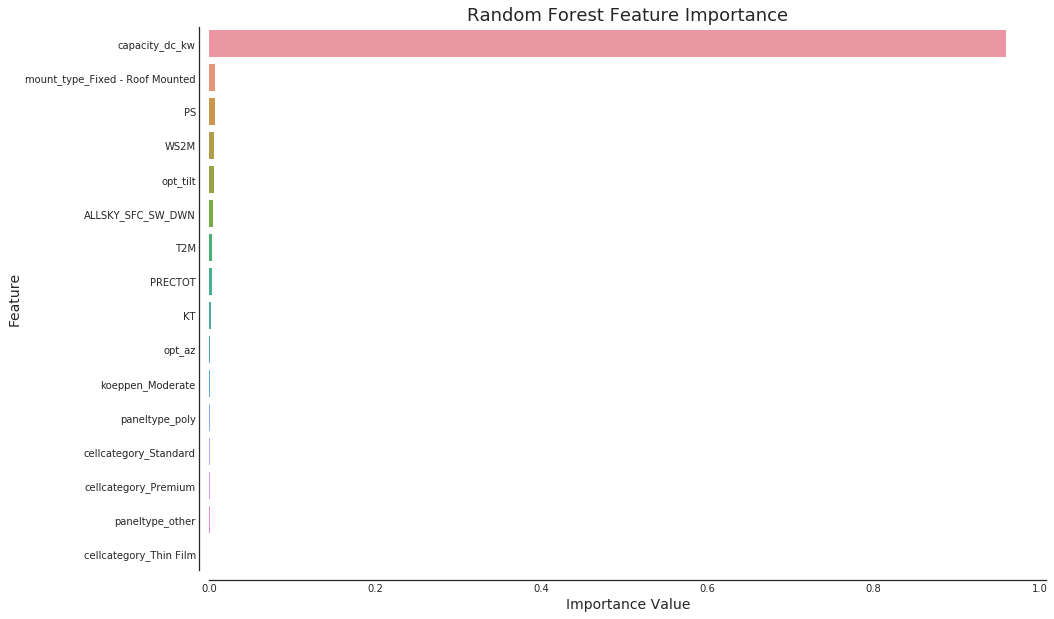

In [98]:
feature_imports = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

feature_imports.sort_values('importance', inplace=True, ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imports.importance.head(16), y=feature_imports.feature.head(16), orient='h')
sns.set_style('white')
sns.despine(offset=10, trim=False)
plt.title('Random Forest Feature Importance', fontsize='18')
plt.xlabel('Importance Value',fontsize='14')
plt.ylabel('Feature',fontsize='14');

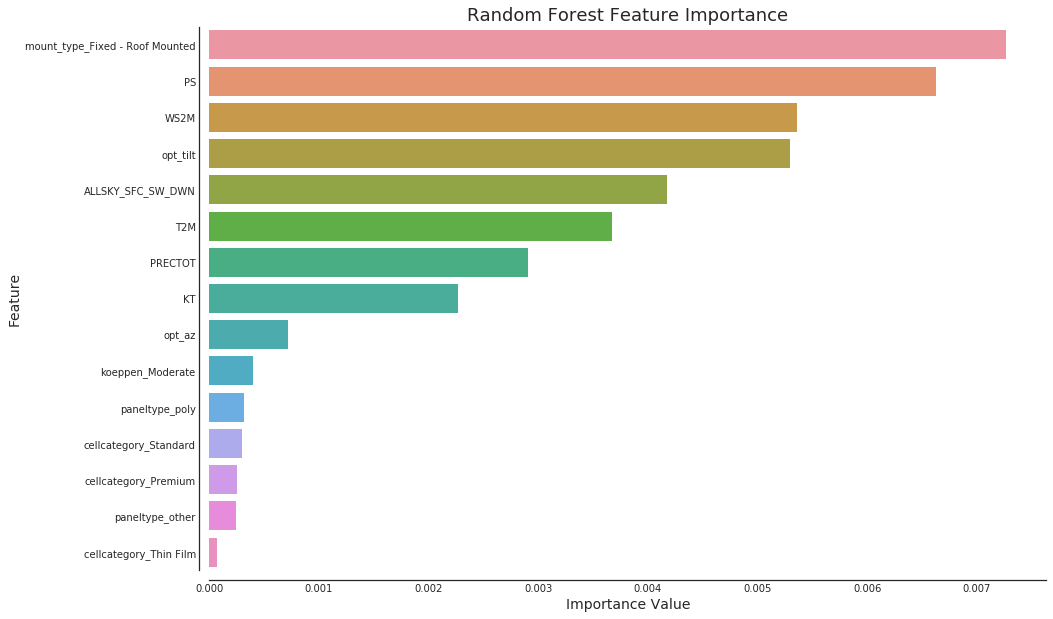

In [99]:
feature_imports = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

feature_imports.sort_values('importance', inplace=True, ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=feature_imports.importance.tail(15), y=feature_imports.feature.tail(15), orient='h')
sns.set_style('white')
sns.despine(offset=10, trim=False)
plt.title('Random Forest Feature Importance', fontsize='18')
plt.xlabel('Importance Value',fontsize='14')
plt.ylabel('Feature',fontsize='14');